# Data Cleaning

The purpose of this notebook is to clean the data generated in notebook "0. Data Collection". I will clean each source and generate multiple dataframes to later model language. 

## 1. Environment Creation

### 1.1 Library Import

In [1]:
''' OS MANAGEMENT '''
import os

''' DATA MANAGEMENT '''
import pandas as pd
import regex as re

''' DATA STRUCTURING '''
import ast 

''' TEXT PROCESSING '''
import nltk
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

from nltk.stem import WordNetLemmatizer 
lem = WordNetLemmatizer() 



''' DATA VISUALIZATION '''
import seaborn as sb
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### 1.2 Data Import

In [4]:
''' NEWS ARTICLE IMPORT'''
republican_news = pd.read_csv("NEWSAPI - republican climate articles raw.csv")
democrat_news = pd.read_csv("NEWSAPI - democrat climate articles raw.csv")

republican_news.drop(columns='Unnamed: 0',inplace=True)
democrat_news.drop(columns='Unnamed: 0',inplace=True)

''' EPA BILL IMPORT '''
bills = pd.read_csv(r"Bill Information Full FINAL.csv")
bills.drop(columns='Unnamed: 0',inplace=True)

''' PARTY PLATFORM IMPORT '''
with open("democrat_party_platform.txt", "r") as file:
    democrat_pdf = file.read()
    
    
with open("republican_party_platform.txt",'r') as f:
    republican_pdf = f.read()

### 1.3 Function Definition

In [5]:
''' 🫧🧼 | now lets create a cleaning function '''

def text_cleaner(text):
    try:
        scrubbed_text1 = re.sub('\d',' ',text)
        scrubbed_text2 = re.findall('\w+',scrubbed_text1)
        scrubbed_text3 = ' '.join(scrubbed_text2)
        scrubbed_text = scrubbed_text3.lower()
        clean_text = scrubbed_text.strip(" ")
        
        return(clean_text)
    
    except:
        return(text)

In [6]:
''' Code Source: Gates Bolton Analytics'''

def stemmer(string):
    try:
        words = re.sub(r"[^A-Za-z\-]", " ", string).lower().split()
        words = [ps.stem(word) for word in words]
        return words
    except:
        return ("")

def lemmer(string):
    try:
        words = re.sub(r"[^A-Za-z\-]", " ", string).lower().split()
        words = [lem.lemmatize(word) for word in words]
        return words
    except:
        return ("")

In [7]:
def count_vectorizer_creation(max_features,content,labels,label_colname):
    ''' COUNT VECTORIZER INSTANTIATION'''

    ## Instantiating the model, the filename parameter will take the list of file names
    ## filter for English stopwords, and take a max feature of 50
    count_vec = CountVectorizer(input='content',  stop_words='english', max_features=max_features, min_df=2,max_df=700)

    ## Fitting the model to the corpus
    model = count_vec.fit_transform(content)
    
    ''' EXTRACTING FEATURES'''

    ## Using get feature names out to name the columns
    columns = count_vec.get_feature_names_out()

    ## Creating the dataframe 
    vect_dataframe = pd.DataFrame(model.toarray(),columns=columns)
    
    ''' ADDING LABELS '''
    if type(labels) == list:
        vect_dataframe.insert(0,label_colname,labels)
        
    else:
        vect_dataframe = pd.concat([labels,vect_dataframe],axis=1)
        
    return (vect_dataframe)

In [8]:
def tfidf_vectorizer_creation(max_features,content,labels,label_colname):
    ''' INSTANTIATING THE MODEL '''

    ## Input is set to content here because I will be passing in a list of the descriptions from the CSV File
    tfidf_vec = TfidfVectorizer(input='content',stop_words='english',max_features=max_features,min_df=2,max_df=700)

    ''' TRAINING THE MODEL '''
    tfidf_model = tfidf_vec.fit_transform(content)

    ''' STRUCTURING THE DATAFRAME '''
    tfidf_columns = tfidf_vec.get_feature_names_out()
    tfidf_df =pd.DataFrame(tfidf_model.toarray(),columns=tfidf_columns)
        
    ''' ADDING LABELS '''
    if type(labels) == list:
        tfidf_df.insert(0,label_colname,labels)
        
    else:
        tfidf_df = pd.concat([labels,tfidf_df],axis=1)
        
    return (tfidf_df)

## 2. News Article Cleaning

In [92]:
republican_news.head(1)

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'the-verge', 'name': 'The Verge'}",Nilay Patel,Trump’s first 100 days: all the news impacting...,"President Donald Trump is taking on TikTok, el...",https://www.theverge.com/24348851/donald-trump...,https://cdn.vox-cdn.com/thumbor/Nwo4_i4giY8lRM...,2025-01-22T14:30:00Z,"Filed under:\r\nByLauren Feiner, a senior poli..."


In [94]:
republican_label = []
for i in range(0,len(republican_news)):
    republican_label.append('Republican')
    
democrat_label = []
for i in range(0,len(democrat_news)):
    democrat_label.append('Democrat')
    
republican_news['Party'] = republican_label
democrat_news['Party'] = democrat_label

In [131]:
news_data = pd.concat([republican_news,democrat_news])
news_data.reset_index(inplace=True)
news_data = news_data[['Party','source','title','description',]]

In [132]:
## Now fixing the source
def source_fixer(source):
    source_dict = ast.literal_eval(source)
    source_name = source_dict['name']
    return (source_name)

In [133]:
publisher = []
for article in range(0,len(news_data)):
    source_raw = news_data.at[article,'source']
    source_name = source_fixer(source_raw)
    publisher.append(source_name)
    
## Appending the column to track the source
news_data['publisher'] = publisher
news_data.drop(columns='source',inplace=True)

In [152]:
''' CLEANING THE TITLES '''
clean_titles = []
for article in range(0,len(news_data)):
    title_raw = news_data.at[article,'title']
    title = text_cleaner(title_raw)
    clean_titles.append(title)
    
## Appending the column to track the source
news_data['clean title'] = clean_titles

''' CLEANING THE DESCRIPTIONS '''
clean_descriptions = []
for article in range(0,len(news_data)):
    description_raw = news_data.at[article,'description']
    description = text_cleaner(description_raw)
    clean_descriptions.append(description)
    
## Appending the column to track the source
news_data['clean description'] = clean_descriptions


In [153]:
''' APPENDING THE COLUMNS FOR LARGER CONTEXT '''
news_data['title + description'] = news_data['clean title'] +" " + news_data['clean description']

In [154]:
news_data.head(3)

,Party,title,description,publisher,clean title,clean description,title + description
0,Republican,Trump’s first 100 days: all the news impacting...,"President Donald Trump is taking on TikTok, el...",The Verge,trump s first days all the news impacting the ...,president donald trump is taking on tiktok ele...,trump s first days all the news impacting the ...
1,Republican,The Quiet Death of Biden’s Climate Corps—and W...,Biden's green jobs program was never what it s...,Gizmodo.com,the quiet death of biden s climate corps and w...,biden s green jobs program was never what it s...,the quiet death of biden s climate corps and w...
2,Republican,The peanut farmer who rose to US president and...,The US president struggled in the White House ...,BBC News,the peanut farmer who rose to us president and...,the us president struggled in the white house ...,the peanut farmer who rose to us president and...


In [260]:
news_data.dropna(inplace=True)
news_data.reset_index(inplace=True)

In [261]:
news_data.to_csv("News Data Cleaned.csv")

In [159]:
print (news_data.at[169,'title'])
print (news_data.at[169,'description'])

print ("\nCleaned and Combined Title and Description----------------")
print (news_data.at[169,'title + description'])

The Trump-Newsom Fight Over an Alleged 'Water Restoration Declaration,' Explained
Trump claimed Newsom's refusal to sign the document led to a water shortage during the Los Angeles fires. But there's more to the story.

Cleaned and Combined Title and Description----------------
the trump newsom fight over an alleged water restoration declaration explained trump claimed newsom s refusal to sign the document led to a water shortage during the los angeles fires but there s more to the story


In [255]:
publisher_counts = Counter(news_data['publisher'].to_list())

In [256]:
count = pd.DataFrame.from_dict(publisher_counts,orient='index',columns=['Count'])

In [257]:
print (f"There are {len(count)} unique sources in the dataset.")

There are 166 unique sources in the dataset.


In [258]:
labels = news_data[['Party','publisher']]

#### 2.2.1 Stemming

In [262]:
stemmed_texts = []
for article in range(0,len(news_data)):
    text = news_data.at[article,'title + description']
    stemmed = stemmer(text)
    st = ' '.join(stemmed)
    stemmed_texts.append(st)

In [263]:
stemmed_texts[0]

'trump s first day all the news impact the tech industri presid donald trump is take on tiktok electr vehicl polici and ai in hi first day in offic thi time around he ha the back of mani tech billionair'

In [264]:
news_vec_stemmed = count_vectorizer_creation(100000,stemmed_texts,labels,['Party','publisher'])

In [265]:
news_vec_stemmed

,Party,publisher,aapi,abandon,abc,abil,abl,abolish,abort,abov,...,yekel,york,young,youth,zealot,zeldin,zer,zero,zone,zuckerberg
0,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
817,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
818,Democrat,The Times of India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
819,Democrat,The Times of India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
news_vec_stemmed.to_csv("News Articles Stemmed- Count Vectorizer.csv")

In [267]:
news_tfidf_stemmed = tfidf_vectorizer_creation(100000,stemmed_texts,labels,['Party','publisher'])

In [268]:
news_tfidf_stemmed

,Party,publisher,aapi,abandon,abc,abil,abl,abolish,abort,abov,...,yekel,york,young,youth,zealot,zeldin,zer,zero,zone,zuckerberg
0,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
817,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
818,Democrat,The Times of India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20093,0.0
819,Democrat,The Times of India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
news_tfidf_stemmed.to_csv("News Articles Stemmed- TFIDF.csv")

#### 2.2.2 Lemmatization

In [270]:
lemmed_texts = []
for article in range(0,len(news_data)):
    text = news_data.at[article,'title + description']
    lemmed = lemmer(text)
    lt = ' '.join(lemmed)
    lemmed_texts.append(lt)

In [271]:
news_vec_lemmed = count_vectorizer_creation(10000,lemmed_texts,labels,['Party','publisher'])

In [272]:
news_vec_lemmed

,Party,publisher,aapi,abandon,abandoned,abc,ability,able,abolish,abortion,...,yes,york,young,youth,zealot,zeldin,zero,zers,zone,zuckerberg
0,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
817,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
818,Democrat,The Times of India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
819,Democrat,The Times of India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
news_vec_lemmed.to_csv("News Articles Lemmed- Count Vectorizer.csv")

In [274]:
news_tfidf_lemmed = tfidf_vectorizer_creation(10000,lemmed_texts,labels,['Party','publisher'])

In [275]:
news_tfidf_lemmed

,Party,publisher,aapi,abandon,abandoned,abc,ability,able,abolish,abortion,...,yes,york,young,youth,zealot,zeldin,zero,zers,zone,zuckerberg
0,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Republican,BBC News,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
817,Democrat,PBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
818,Democrat,The Times of India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201006,0.0
819,Democrat,The Times of India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
news_tfidf_lemmed.to_csv("News Articles Lemmed- TFIDF.csv")

#### 2.2.3 CountVectorizer

In [277]:
texts = news_data['title + description'].to_list()

In [278]:
news_vec = count_vectorizer_creation(10000,texts,labels,['Party','publisher'])

In [279]:
news_vec.to_csv("News Articles - Count Vectorizer.csv")

#### 2.2.4 TF-IDF Vectorizer

In [280]:
news_tfidf = tfidf_vectorizer_creation(10000,texts,labels,['Party','publisher'])

In [281]:
news_tfidf.to_csv("News Articles - TF-IDF.csv")

## 3. EPA Bill Cleaning

In [11]:
bills.head(1)

,API URL,Congress Number,Bill Type,Bill Number,Legislation Number,URL_y,Congress,Title,Sponsor,Date of Introduction,...,Number of Cosponsors,Amends Bill,Date Offered,Date Submitted,Date Proposed,Amends Amendment,Sponser Affiliation,Sponser State,Bill Title (XML),Bill Text
0,https://www.congress.gov/119/bills/hr375/BILLS...,119,hr,375,H.R. 375,https://www.congress.gov/bill/119th-congress/h...,119th Congress (2025-2026),Continued Rapid Ohia Death Response Act of 2025,"Tokuda, Jill N. [Rep.-D-HI-2] (Introduced 01/1...",1/13/2025,...,1,NaN,NaN,NaN,NaN,NaN,D,HI,<dc:title>119 HR 375 : Continued Rapid Ohia De...,\n\n119 HR 375 : Continued Rapid Ohia Death Re...


In [12]:
''' CLEANING THE BILLS '''
clean_bills= []
for bill in range(0,len(bills)):
    bill_text_raw = bills.at[bill,'Bill Text']
    clean_bill = text_cleaner(bill_text_raw)
    clean_bills.append(clean_bill)
    
## Appending the column to track the source
bills['Bill Text Clean'] = clean_bills

In [13]:
texts = clean_bills

In [14]:
labels = bills[['Bill Type','Sponser Affiliation','Sponser State','Committees']]

#### 3.2.1 Stemming

In [15]:
stemmed_texts = []
for article in range(0,len(bills)):
    text = bills.at[article,'Bill Text Clean']
    stemmed = stemmer(text)
    st = ' '.join(stemmed)
    stemmed_texts.append(st)

In [16]:
stemmed_texts[0]

'hr continu rapid ohia death respons act of u s hous of repres text xml en pursuant to titl section of the unit state code thi file is not subject to copyright protect and is in the public domain iib th congress st sessionh r in the senat of the unit statesjanuari receiv read twice and refer to the committe on agricultur nutrit and forestryan actto requir the secretari of the interior to partner and collabor with the secretari of agricultur and the state of hawaii to address rapid ohia death and for other purpos short titlethi act may be cite as the continu rapid ohia death respons act of definitionsin thi act rapid ohia deathth term rapid ohia death mean the diseas caus by the fungal pathogen known as ceratocysti fimbriata that affect the tree of the speci metrosidero polymorpha stateth term state mean the state of hawaii collaborationth secretari of the interior shall partner and collabor with the secretari of agricultur and the state to address rapid ohia death sustain effort a tran

In [17]:
bill_vec_stemmed = count_vectorizer_creation(100000,stemmed_texts,labels,['Bill Type','Sponser Affiliation','Sponser State','Committees'])

In [18]:
bill_vec_stemmed

,Bill Type,Sponser Affiliation,Sponser State,Committees,aa,aaa,aarhu,ab,abandon,abandonth,...,zoe,zone,zonea,zonesnotwithstand,zoneth,zoo,zoolog,zoonot,zooplankton,zquez
0,hr,D,HI,"House - Natural Resources, Agriculture | Senat...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hr,R,NY,House - Agriculture,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,hr,R,TX,House - Energy and Commerce,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,hr,R,NY,"House - Transportation and Infrastructure, Nat...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,hr,R,OH,House - Transportation and Infrastructure,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,hr,D,CA,House - Transportation and Infrastructure,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0
3257,hr,R,CO,House - Resources,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3258,hr,D,MI,House - Energy and Commerce,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,s,D,NJ,Senate - Environment and Public Works,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
bill_vec_stemmed.to_csv("Bills Stemmed- Count Vectorizer.csv")

In [20]:
bill_tfidf_stemmed = tfidf_vectorizer_creation(100000,stemmed_texts,labels,['Bill Type','Sponser Affiliation','Sponser State','Committees'])

In [21]:
bill_tfidf_stemmed

,Bill Type,Sponser Affiliation,Sponser State,Committees,aa,aaa,aarhu,ab,abandon,abandonth,...,zoe,zone,zonea,zonesnotwithstand,zoneth,zoo,zoolog,zoonot,zooplankton,zquez
0,hr,D,HI,"House - Natural Resources, Agriculture | Senat...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,hr,R,NY,House - Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,hr,R,TX,House - Energy and Commerce,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hr,R,NY,"House - Transportation and Infrastructure, Nat...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,hr,R,OH,House - Transportation and Infrastructure,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,hr,D,CA,House - Transportation and Infrastructure,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.022374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3257,hr,R,CO,House - Resources,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3258,hr,D,MI,House - Energy and Commerce,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3259,s,D,NJ,Senate - Environment and Public Works,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
bill_tfidf_stemmed.to_csv("Bills Stemmed- TFIDF.csv")

#### 3.2.2 Lemmatization

In [23]:
lemmed_texts = []
for article in range(0,len(bills)):
    text = bills.at[article,'Bill Text Clean']
    lemmed = lemmer(text)
    lt = ' '.join(lemmed)
    lemmed_texts.append(lt)

In [24]:
bill_vec_lemmed = count_vectorizer_creation(100000,stemmed_texts,labels,['Bill Type','Sponser Affiliation','Sponser State','Committees'])

In [25]:
bill_vec_lemmed.to_csv("Bills Lemmed- Count Vectorizer.csv")

In [26]:
bill_tfidf_lemmed = tfidf_vectorizer_creation(10000,lemmed_texts,labels,['Party','publisher'])

In [27]:
bill_tfidf_lemmed.to_csv("Bills Lemmed- TFIDF.csv")

#### 3.2.3 CountVectorizer

In [28]:
bill_vec = count_vectorizer_creation(100000,texts,labels,['Bill Type','Sponser Affiliation','Sponser State','Committees'])

In [29]:
bill_vec.to_csv("Bills - Count Vectorizer.csv")

#### 3.2.4 TF-IDF Vectorizer

In [30]:
bill_tfidf = tfidf_vectorizer_creation(100000,texts,labels,['Bill Type','Sponser Affiliation','Sponser State','Committees'])

In [31]:
bill_tfidf.to_csv("Bills - TF-IDF.csv")

### 3.3 Visualizing Before and After Bill Cleaning

In [32]:
raw_example = bills['Bill Text'].to_list()
raw_example_text = raw_example[200]

In [33]:
raw_example_string = ' '.join(raw_example)

In [35]:
clean_example_string = ' '.join(texts)

In [346]:
raw_example_text

'\n\n\n HR 2950 ENR: Coastal Habitat Conservation Act of 2023\nU.S. House of Representatives\n\ntext/xml\nEN\nPursuant to Title 17 Section 105 of the United States Code, this file is not subject to copyright protection and is in the public domain.\n\n\n\nIB\nOne Hundred Eighteenth Congress of the United States of AmericaAt the Second SessionBegun and held at the City of Washington on Wednesday, the third day of January, two thousand and twenty-four\nH. R. 2950\n\nAN ACT\nTo authorize the Secretary of the Interior, through the Coastal Program of the United States Fish and Wildlife Service, to work with willing partners and provide support to efforts to assess, protect, restore, and enhance important coastal landscapes that provide fish and wildlife habitat on which certain Federal trust species depend, and for other purposes.\n\n\n1.Short titleThis Act may be cited as the Coastal Habitat Conservation Act of 2023. 2.PurposeThe purpose of this Act is to legislatively authorize the Coastal

In [341]:
title = bills.at[200,'Title']

In [339]:
clean_example_text = texts[200]

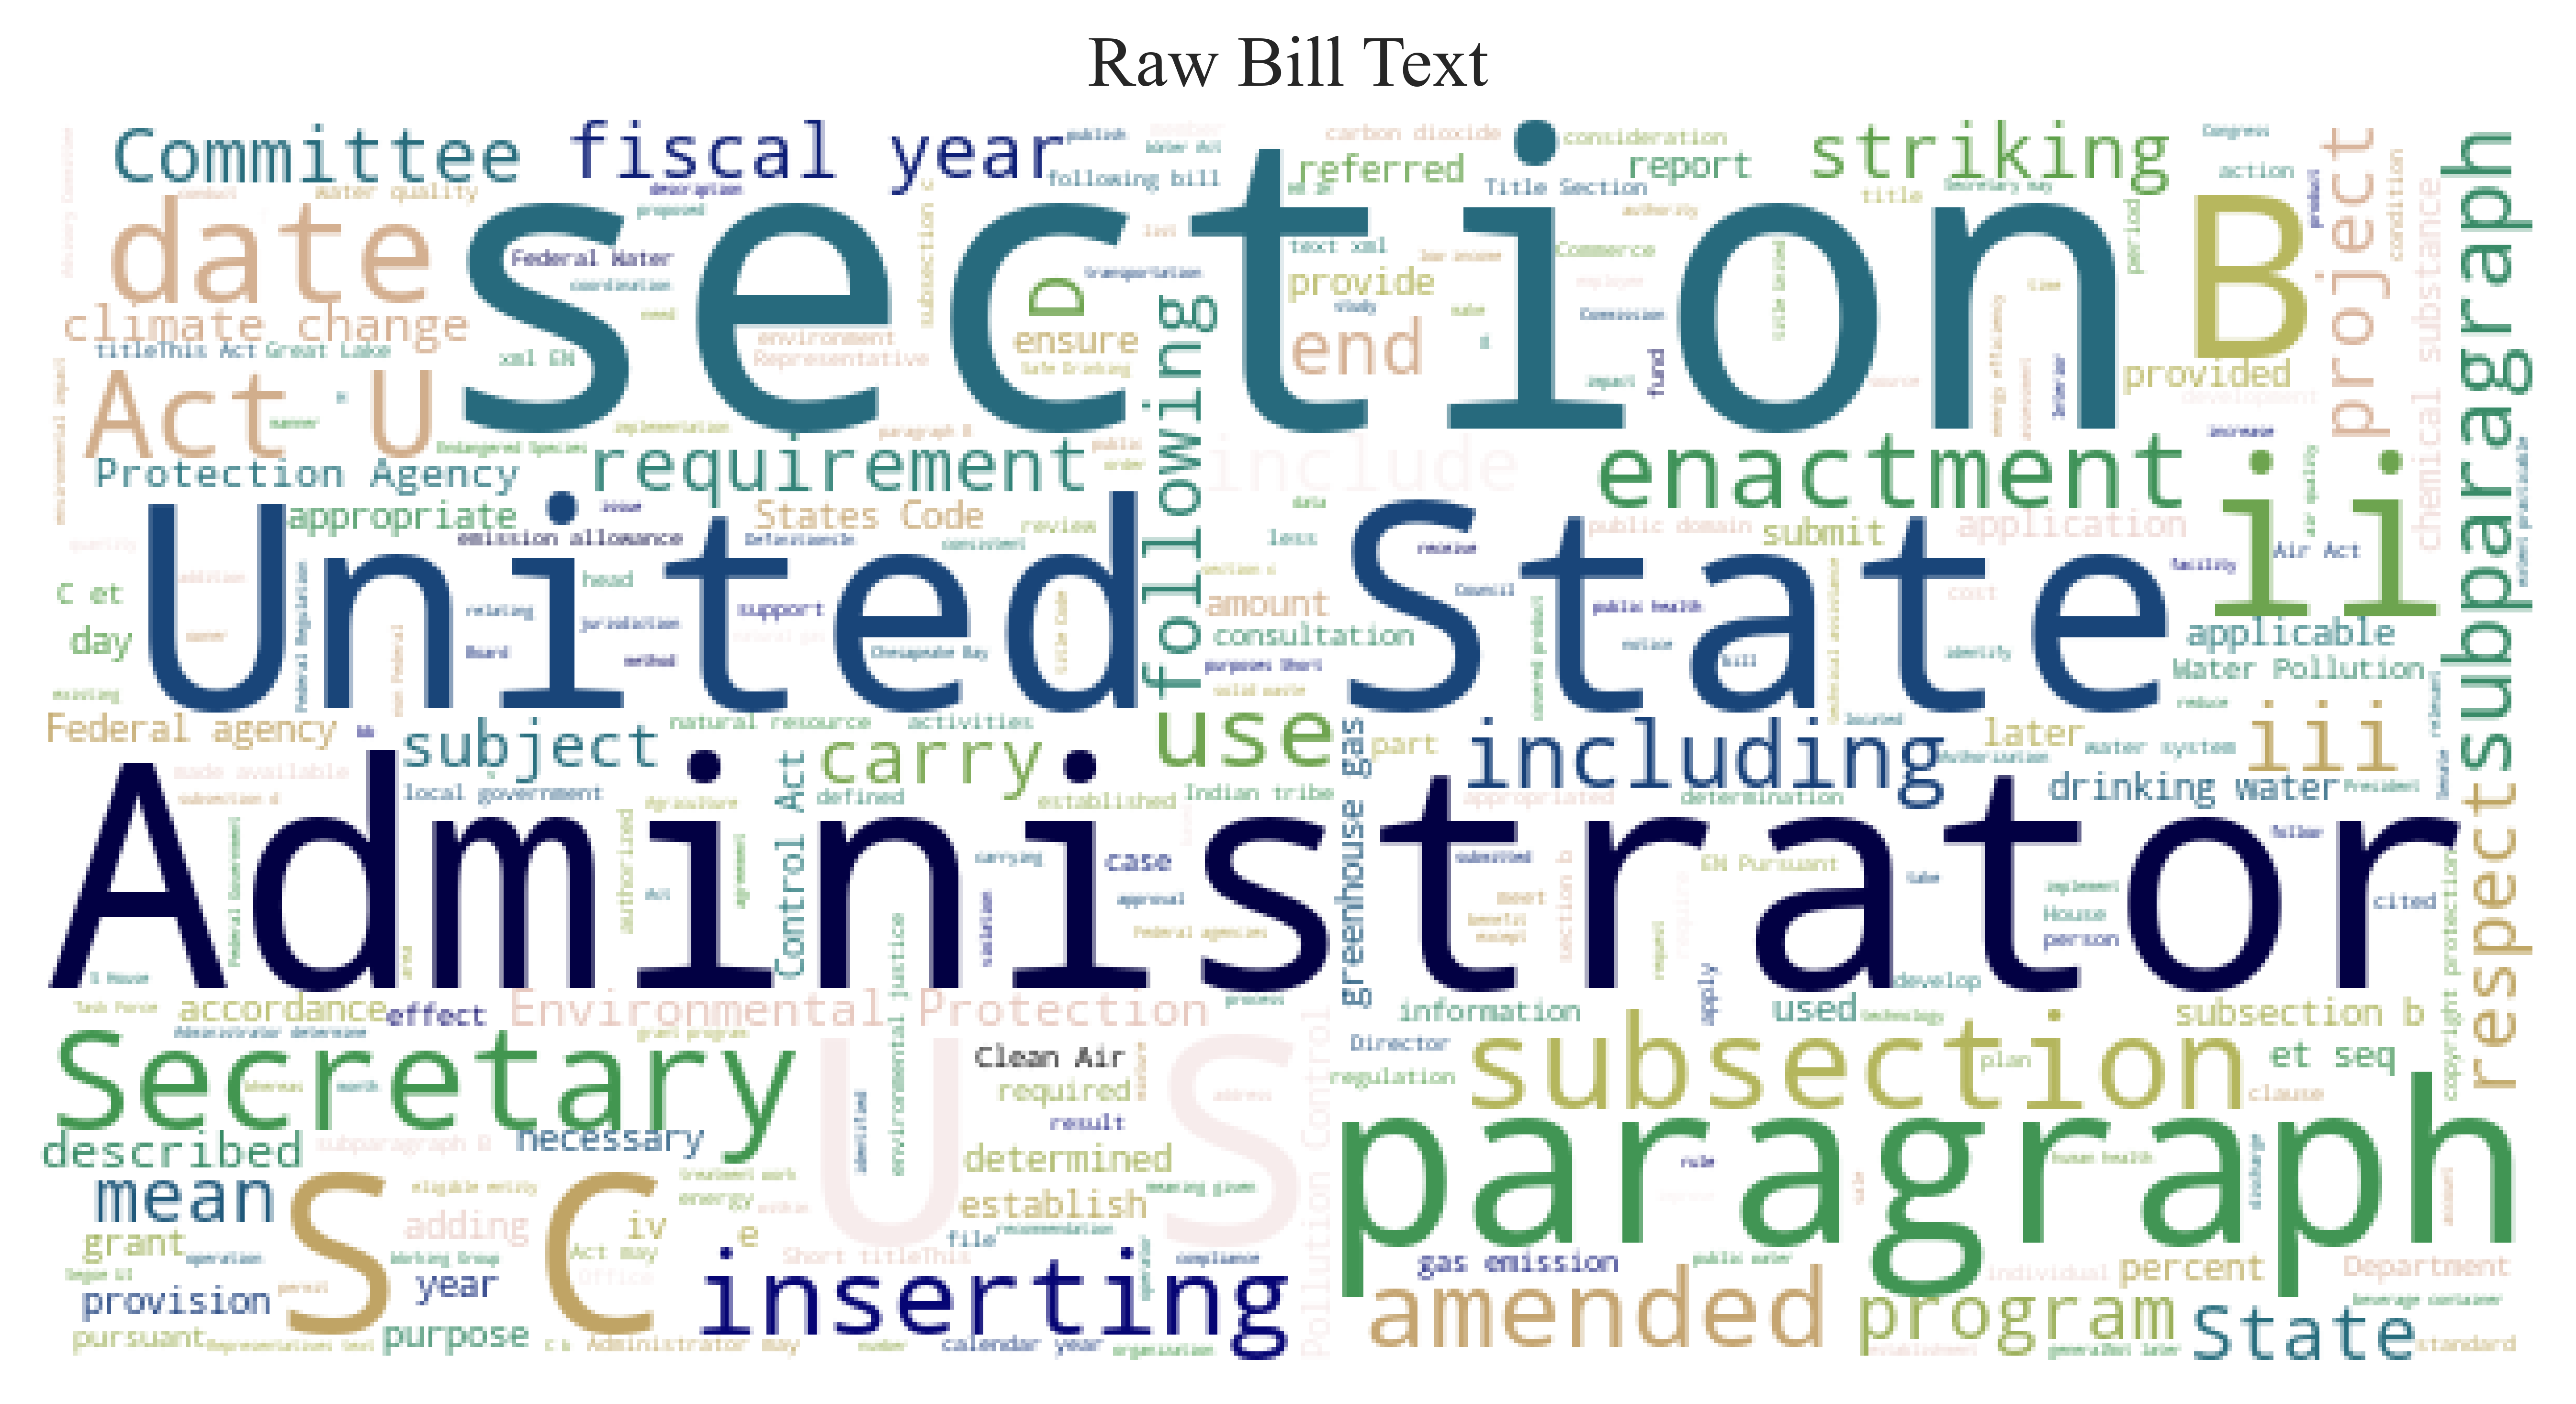

In [41]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='gist_earth_r',max_words=1000)
wc.generate_from_text(raw_example_string)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("Raw Bill Text")
plt.savefig("Bill - Raw Text.png",dpi=1000);

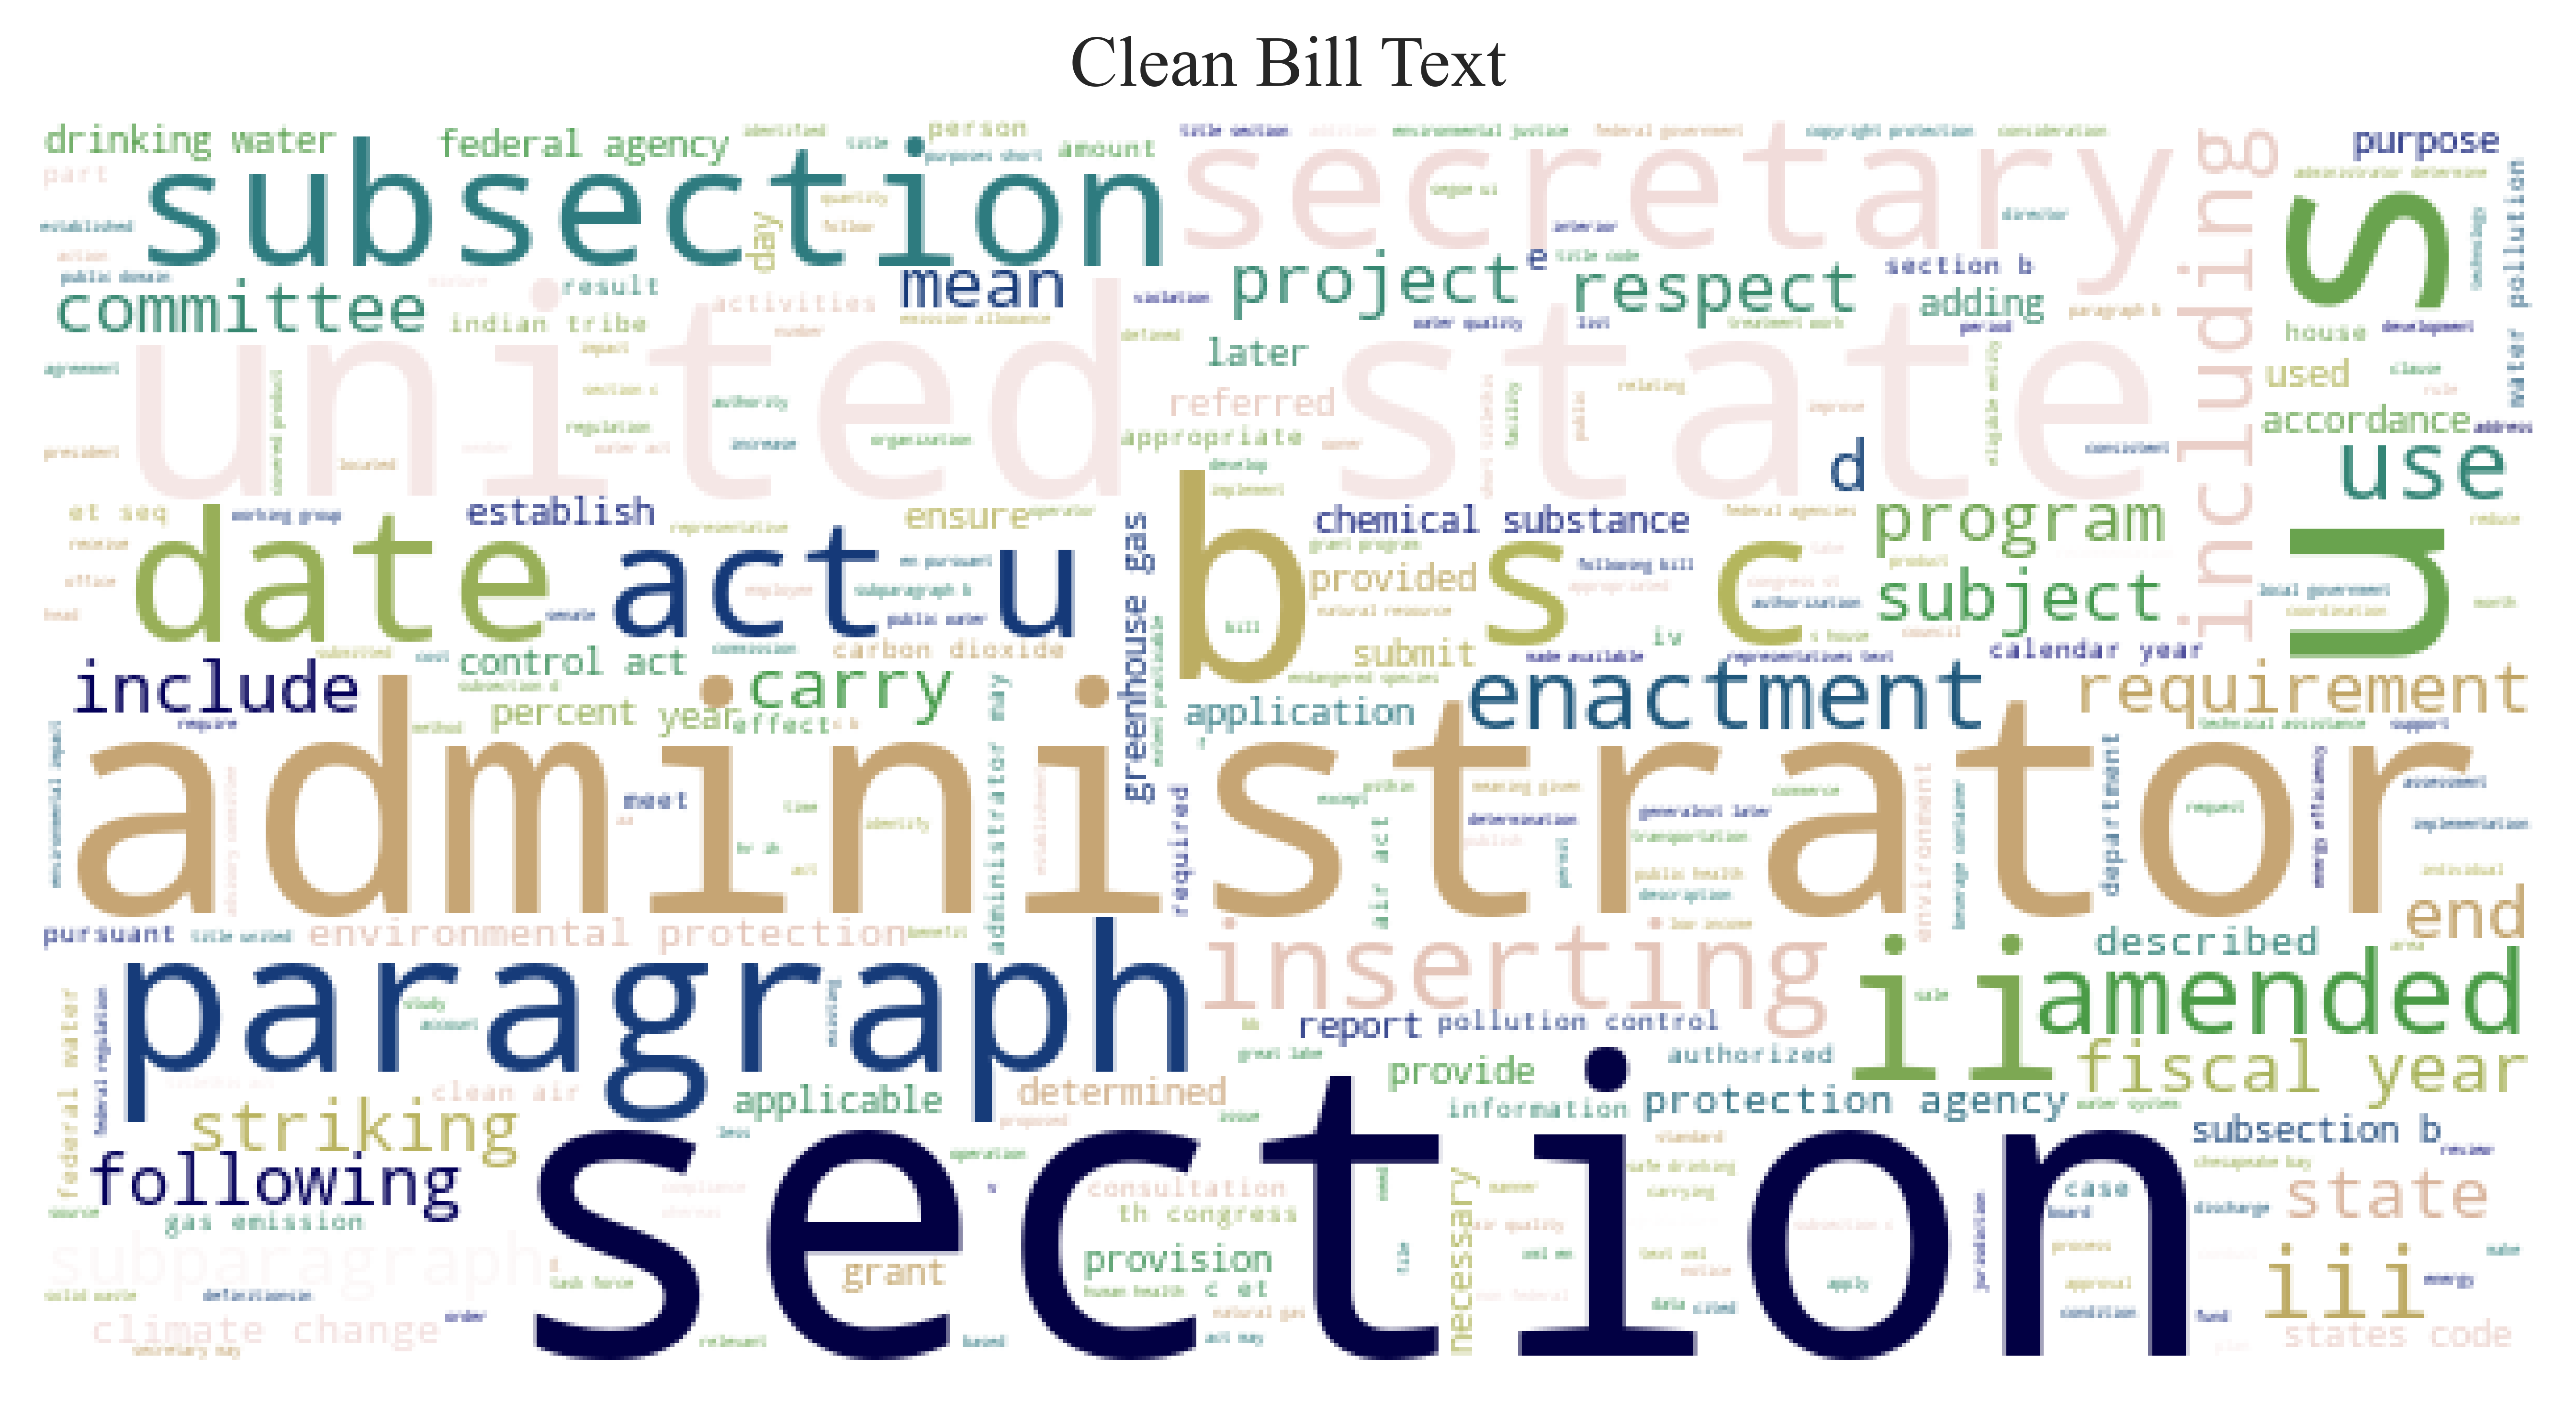

In [42]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='gist_earth_r',max_words=1000)
wc.generate_from_text(clean_example_string)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("Clean Bill Text")
plt.savefig("Bill - Clean Text.png",dpi=1000);

## 4. Party Platform Cleaning

In [4]:
democrat_pdf[0:100]

' Democratic\nNational\nConvention \nLand\nAcknowledgement\nThe\nDemocratic\nNational\nCommittee\nwishes\nto\nac'

In [20]:
republican_pdf[0:100]

'4343RDRD REPUBLICAN NATIONAL CONVENTION REPUBLICAN NATIONAL CONVENTION\nPLATFORMTHE 2024 REPUBLICAN\nM'

### 4.1 Visualizing Raw Data

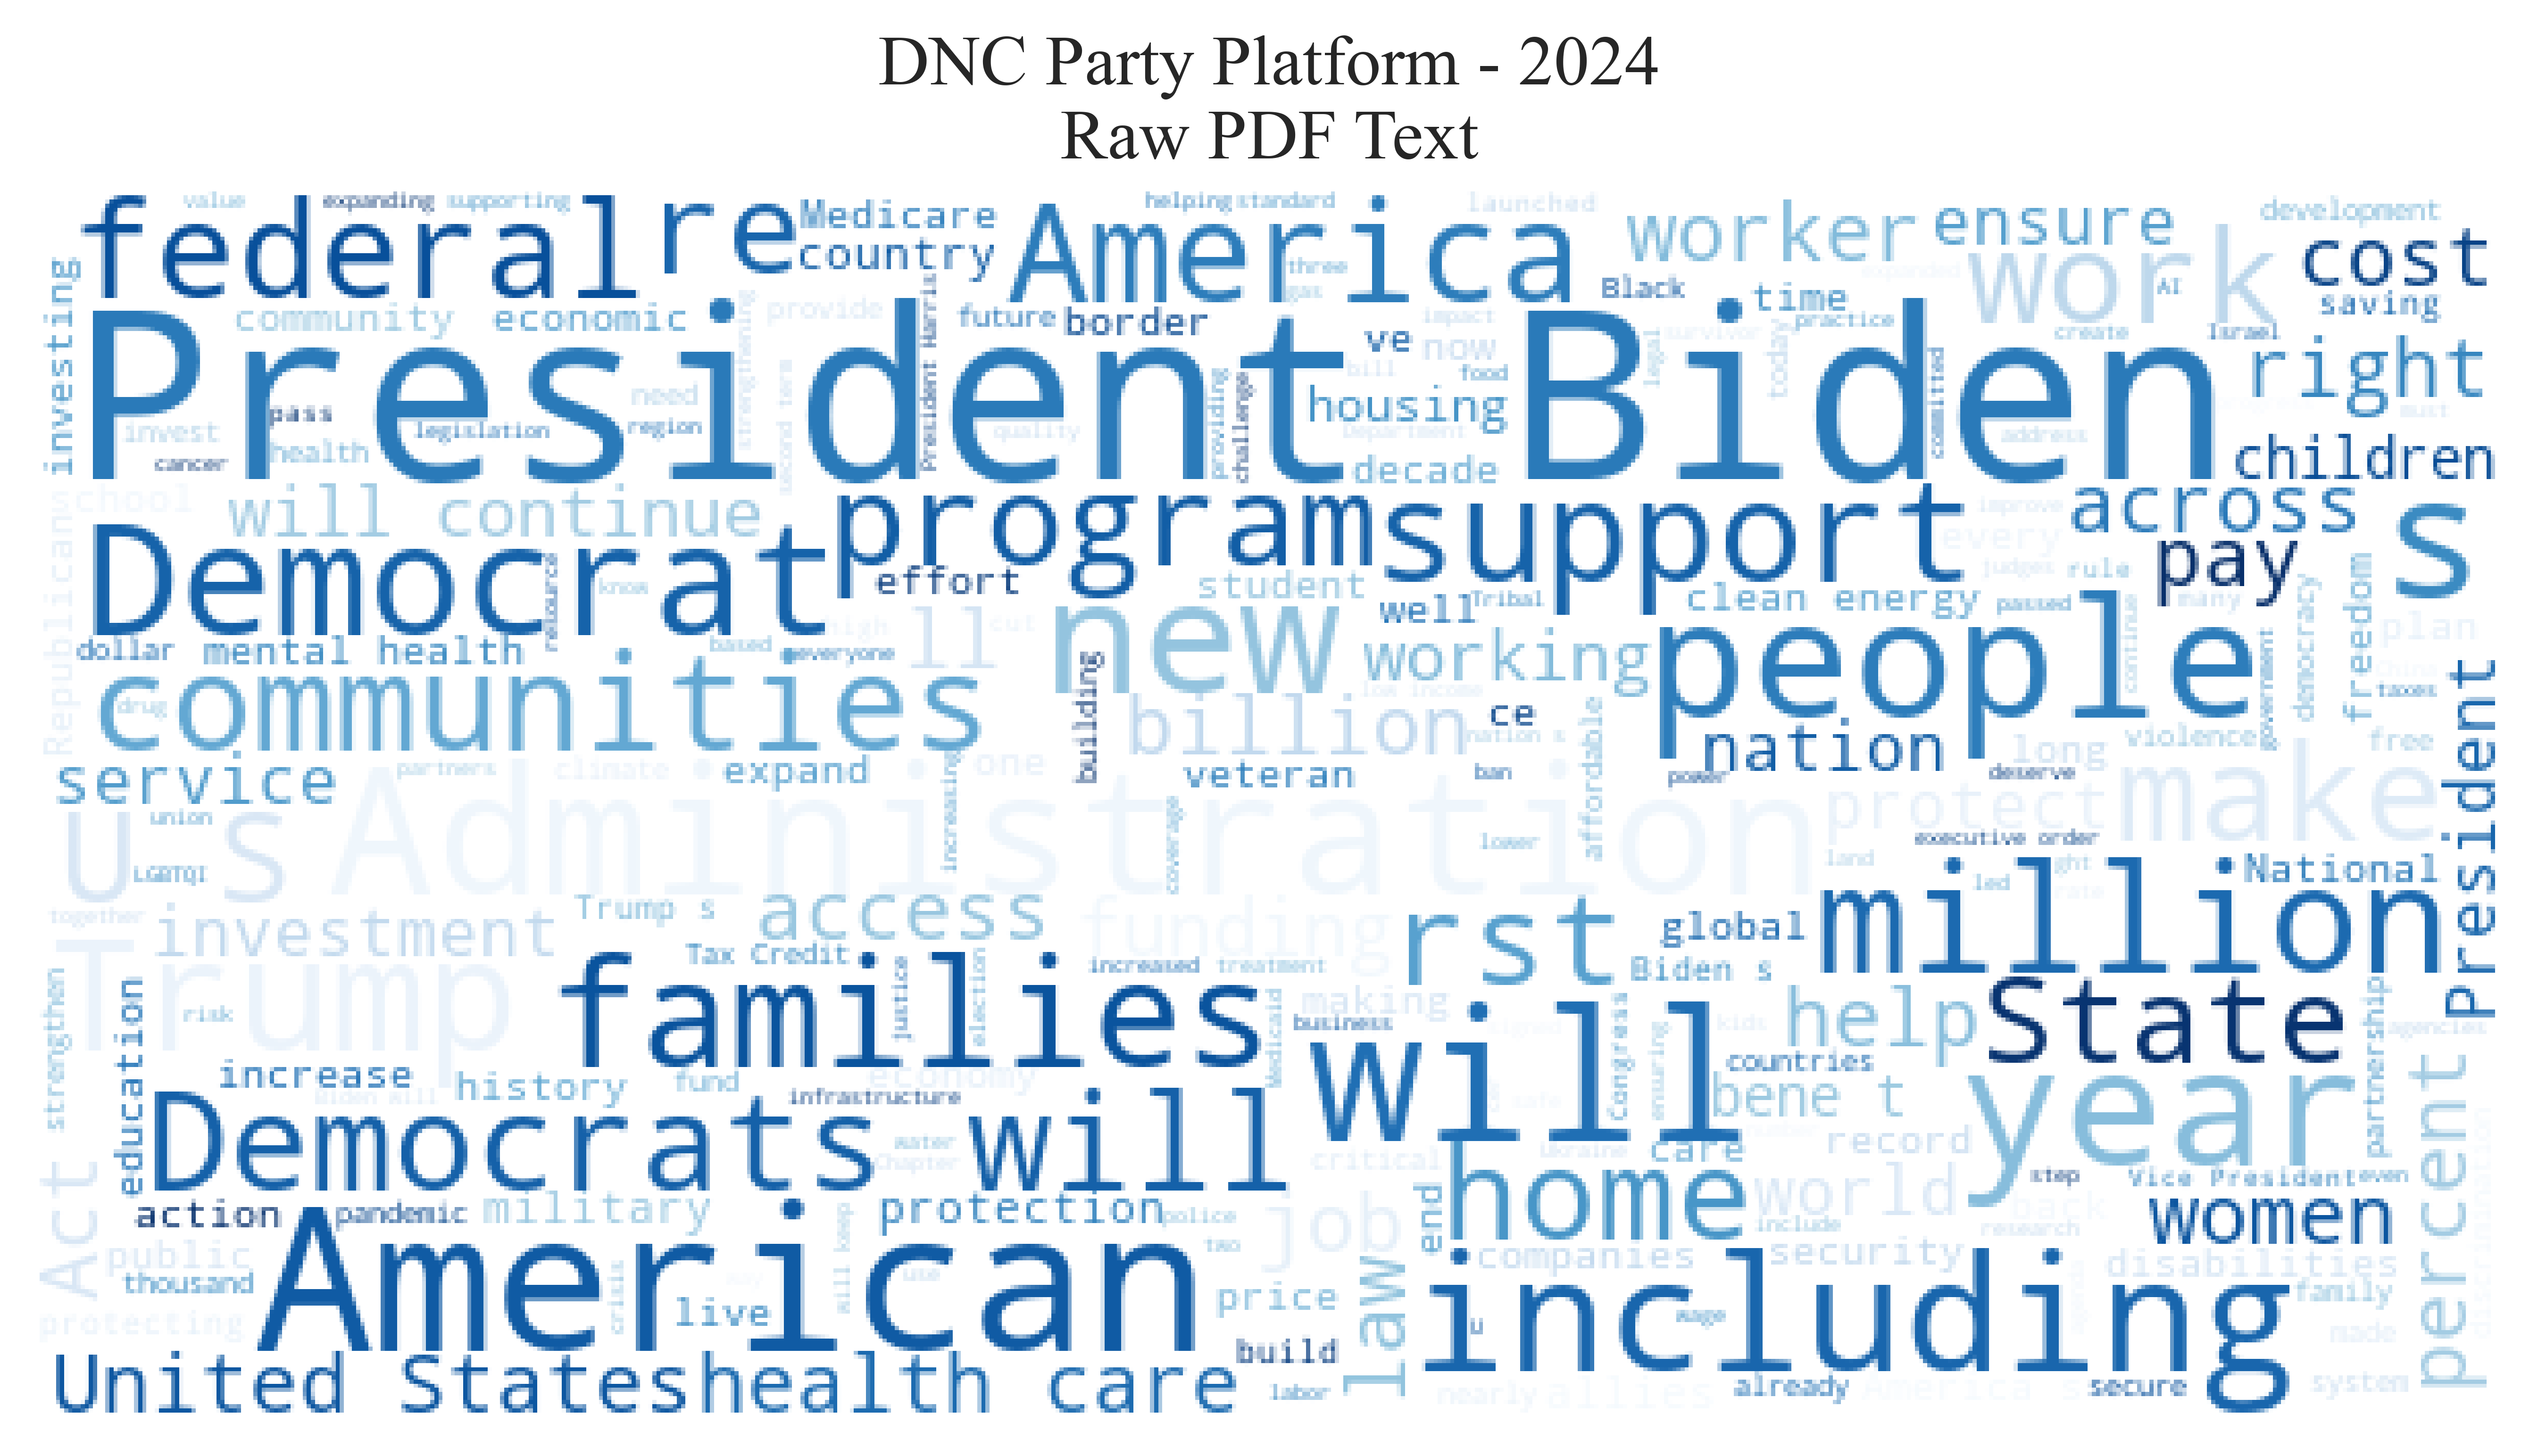

In [14]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='Blues',max_words=250)
wc.generate_from_text(democrat_pdf)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("DNC Party Platform - 2024\nRaw PDF Text")
plt.savefig("DNC Party Platform - Raw Text",dpi=1000);

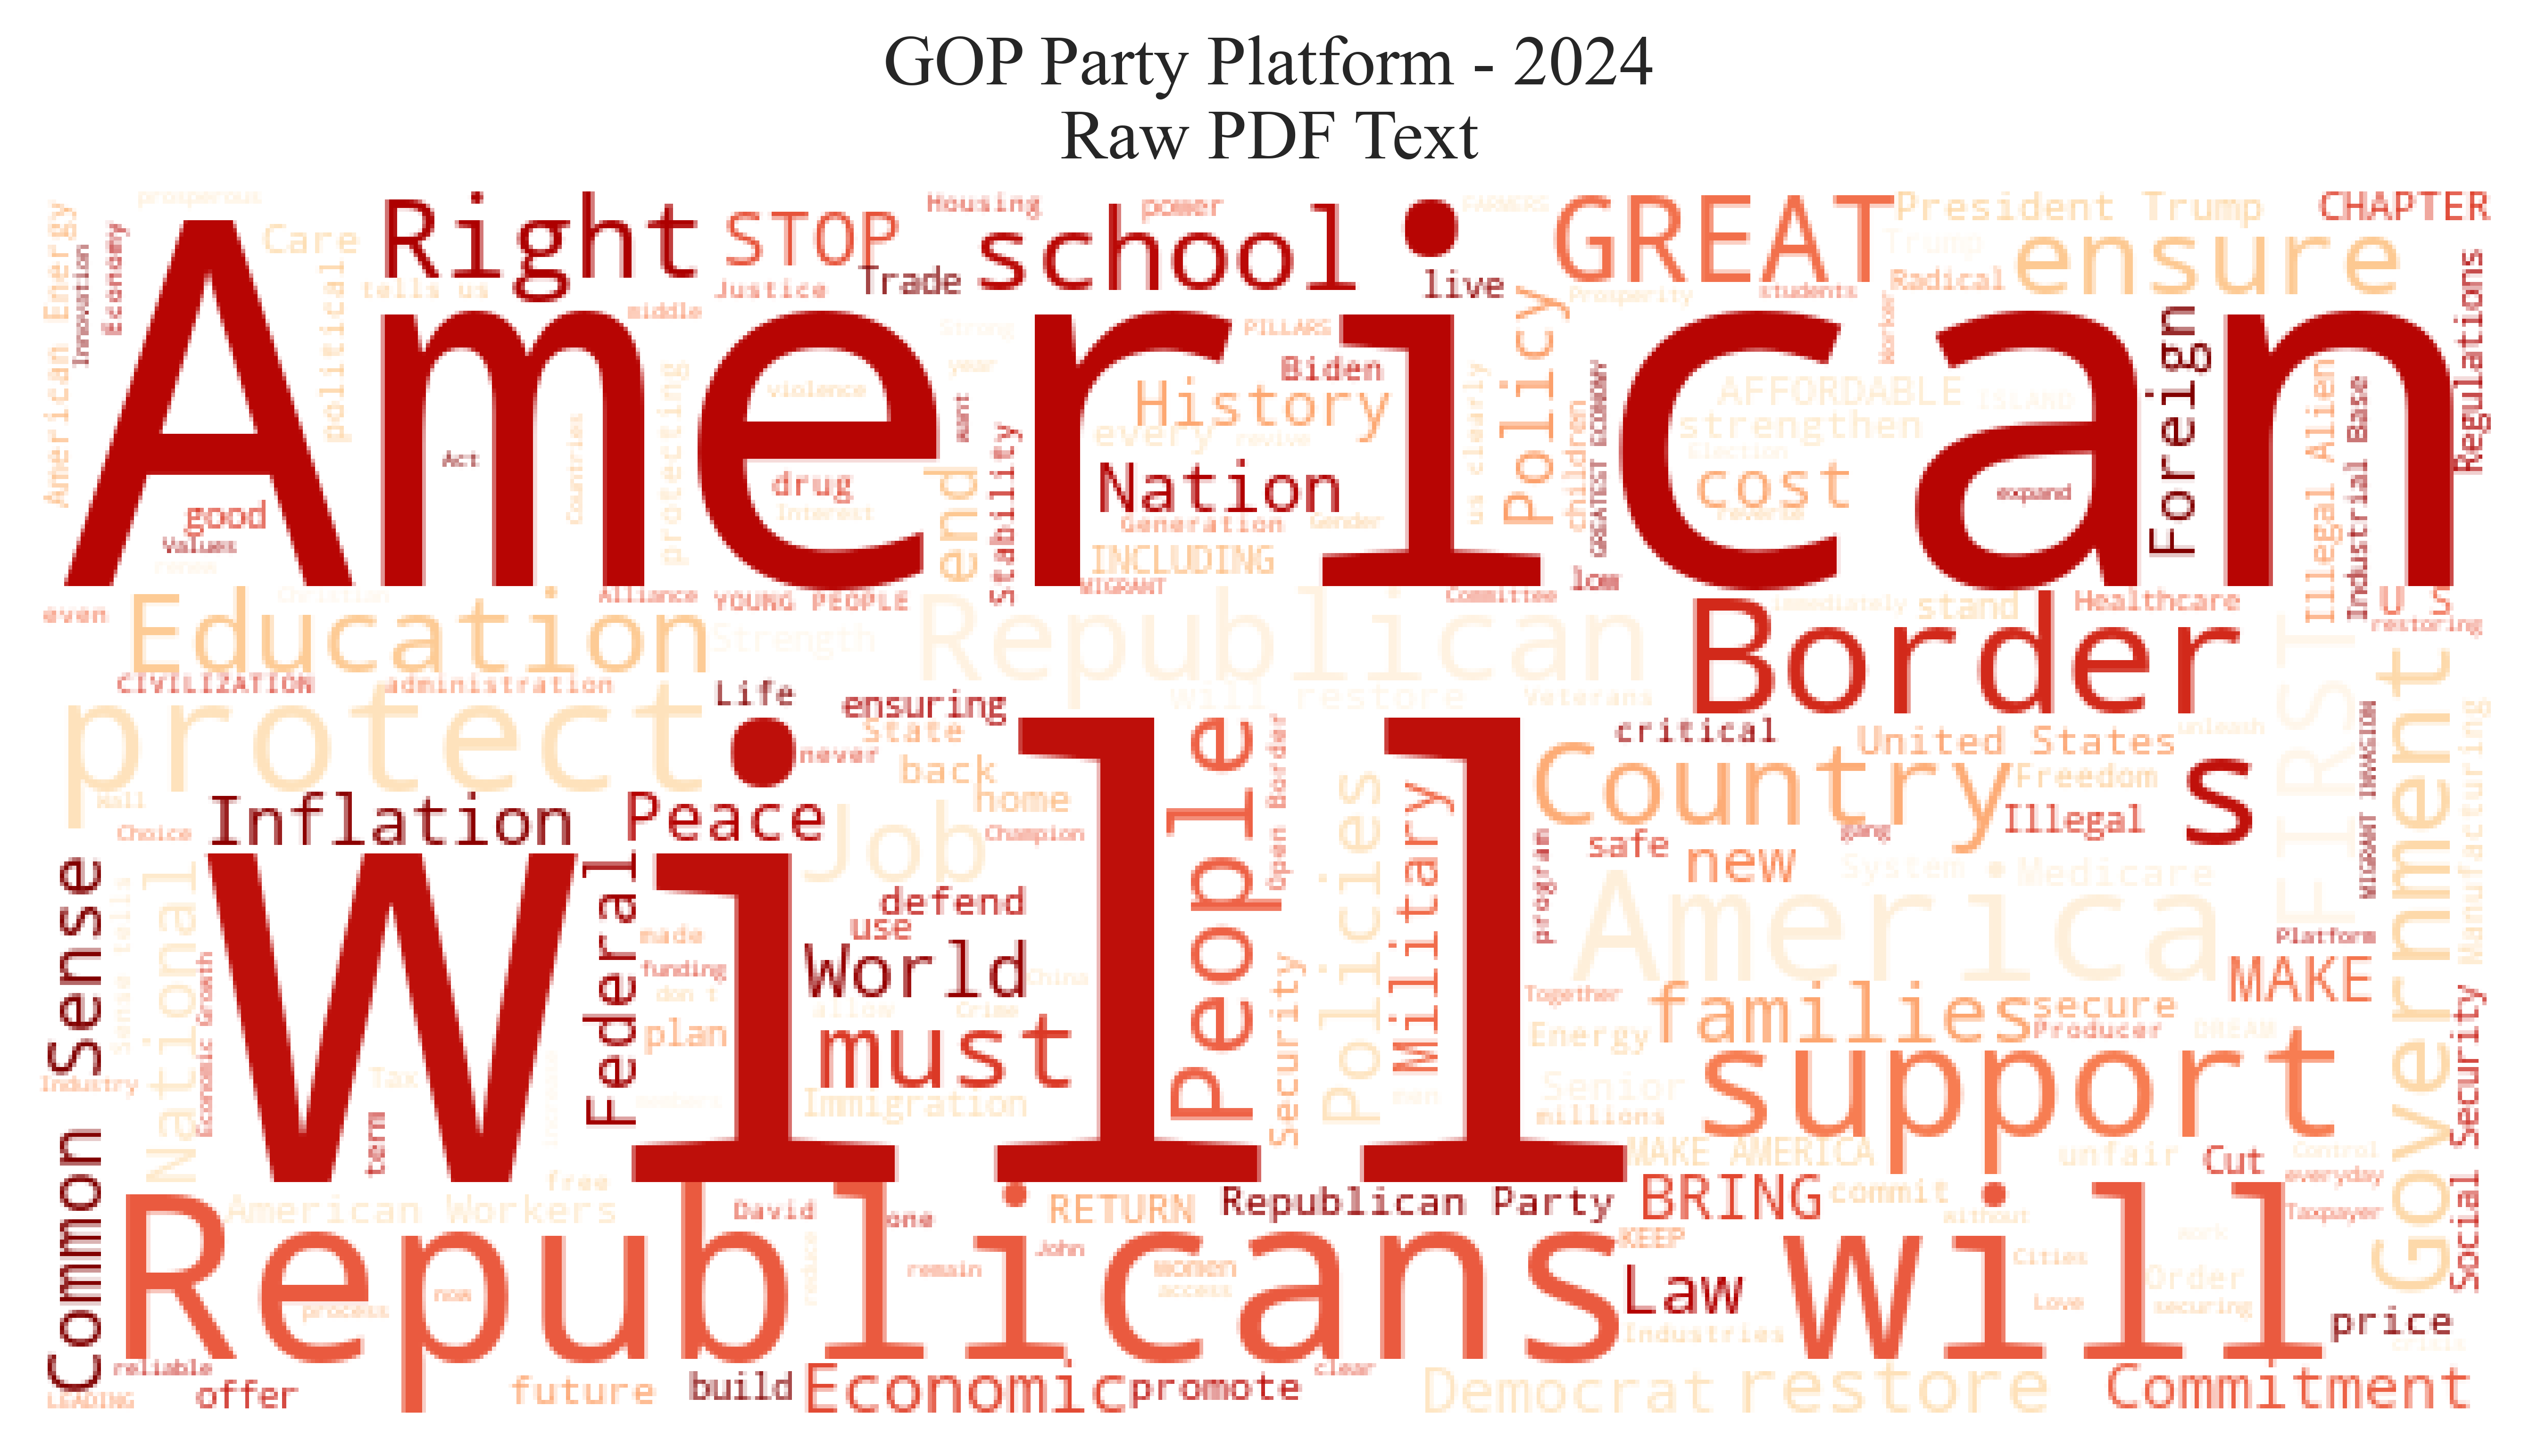

In [18]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='OrRd',max_words=250)
wc.generate_from_text(republican_pdf)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("GOP Party Platform - 2024\nRaw PDF Text")
plt.savefig("GOP Party Platform - Raw Text",dpi=1000);

### 4.2 DF Creation

In [7]:
''' CLEANING THE TEXT -- DEMOCRAT '''

## First, doing some basic cleaning for the text
democrat_text = re.sub('\W',' ',democrat_pdf)

## And Now Stripping Any White Space
democrat_string = democrat_text.strip(" ")

## And Now Splitting!
democrat_text_list = democrat_string.split(" ")

In [33]:
democrat_text_list[0:10]

['Democratic',
 'National',
 'Convention',
 '',
 'Land',
 'Acknowledgement',
 'The',
 'Democratic',
 'National',
 'Committee']

In [8]:
## It looks like there is a few empty characters in here, so now lets clean that up as well and lower the full text,
## and removing numbers
dem_text_clean = []

for word in democrat_text_list:
    if len(word) > 1:
        if len(re.findall("\d",word)) < 1:
            dem_text_clean.append(word.lower())

In [39]:
dem_text_clean[0:10]

['democratic',
 'national',
 'convention',
 'land',
 'acknowledgement',
 'the',
 'democratic',
 'national',
 'committee',
 'wishes']

In [9]:
''' CLEANING THE TEXT -- REPUBLICAN '''

## First, doing some basic cleaning for the text
republican_text = re.sub('\W',' ',republican_pdf)

## And Now Stripping Any White Space
republican_string = republican_text.strip(" ")

## And Now Splitting!
republican_text_list = republican_string.split(" ")

In [37]:
republican_text_list[0:10]

['4343RDRD',
 'REPUBLICAN',
 'NATIONAL',
 'CONVENTION',
 'REPUBLICAN',
 'NATIONAL',
 'CONVENTION',
 'PLATFORMTHE',
 '2024',
 'REPUBLICAN']

In [10]:
## It looks like there is a few empty characters in here, so now lets clean that up as well and lower the full text,
## and removing numbers
rep_text_clean = []

for word in republican_text_list:
    if len(word) > 1:
        if len(re.findall("\d",word)) < 1:
            rep_text_clean.append(word.lower())

In [41]:
rep_text_clean[0:10]

['republican',
 'national',
 'convention',
 'republican',
 'national',
 'convention',
 'platformthe',
 'republican',
 'make',
 'america']

In [11]:
''' CREATING A DATAFRAME '''
rep_text_final = ' '.join(rep_text_clean)
dem_text_final = ' '.join(dem_text_clean)

party_platforms = pd.DataFrame(columns=['Party','Text'])

In [13]:
party_platforms['Party'] = ['Republican','Democrat']
party_platforms['Text'] = [rep_text_final,dem_text_final]

In [14]:
party_platforms

,Party,Text
0,Republican,republican national convention republican nati...
1,Democrat,democratic national convention land acknowledg...


#### 4.2.1 Stemming

In [51]:
rep_stemmed = stemmer(rep_text_final)
dem_stemmed = stemmer(dem_text_final)

rep_stem_text = ' '.join(rep_stemmed)
dem_stem_text = ' '.join(rep_stemmed)

In [84]:
platform_vec_stemmed = count_vectorizer_creation(10000,[rep_stem_text,dem_stem_text],['Republican','Democrat'],'Party')

In [85]:
platform_vec_stemmed

,Party,abernathi,abil,abl,abort,absolut,abund,access,accomplish,accord,...,worst,wrongdoer,www,wyom,year,yob,york,young,zack,zoraida
0,Republican,1,1,1,1,1,3,5,1,2,...,1,1,1,1,7,1,1,7,1,1
1,Democrat,1,1,1,1,1,3,5,1,2,...,1,1,1,1,7,1,1,7,1,1


In [86]:
platform_vec_stemmed.to_csv("Party Platform Stemmed- Count Vectorizer.csv")

In [54]:
platform_tfidf_stemmed = tfidf_vectorizer_creation(10000,[rep_stem_text,dem_stem_text],['Republican','Democrat'],'Party')

In [55]:
platform_tfidf_stemmed

,Party,abernathi,abil,abl,abort,absolut,abund,access,accomplish,accord,...,worst,wrongdoer,www,wyom,year,yob,york,young,zack,zoraida
0,Republican,0.004754,0.004754,0.004754,0.004754,0.004754,0.014261,0.023769,0.004754,0.009508,...,0.004754,0.004754,0.004754,0.004754,0.033277,0.004754,0.004754,0.033277,0.004754,0.004754
1,Democrat,0.004754,0.004754,0.004754,0.004754,0.004754,0.014261,0.023769,0.004754,0.009508,...,0.004754,0.004754,0.004754,0.004754,0.033277,0.004754,0.004754,0.033277,0.004754,0.004754


In [56]:
platform_tfidf_stemmed.to_csv("Party Platform Stemmed- TFIDF.csv")

#### 4.2.2 Lemmatization

In [44]:
rep_lemmed = lemmer(rep_text_final)
dem_lemmed = lemmer(dem_text_final)

rep_lem_text = ' '.join(rep_lemmed)
dem_lem_text = ' '.join(dem_lemmed)

In [45]:
platform_vec_lemmed = count_vectorizer_creation(10000,[rep_lem_text,dem_lem_text],['Republican','Democrat'],'Party')

In [46]:
platform_vec_lemmed

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,won,word,work,worker,working,world,worship,worst,year,young
0,Republican,1,1,1,4,1,1,1,4,1,...,1,1,4,15,2,15,2,1,7,7
1,Democrat,7,13,13,72,15,1,6,14,1,...,10,1,101,79,81,69,4,4,149,10


In [47]:
platform_vec_lemmed.to_csv("Party Platform Lemmed- Count Vectorizer.csv")

In [48]:
platform_tfidf_lemmed = tfidf_vectorizer_creation(10000,[rep_lem_text,dem_lem_text],['Republican','Democrat'],'Party')

In [49]:
platform_tfidf_lemmed

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,won,word,work,worker,working,world,worship,worst,year,young
0,Republican,0.005157,0.005157,0.005157,0.020627,0.005157,0.005157,0.005157,0.020627,0.005157,...,0.005157,0.005157,0.020627,0.077351,0.010314,0.077351,0.010314,0.005157,0.036097,0.036097
1,Democrat,0.006634,0.012320,0.012320,0.068233,0.014215,0.000948,0.005686,0.013268,0.000948,...,0.009477,0.000948,0.095716,0.074867,0.076762,0.065390,0.003791,0.003791,0.141205,0.009477


In [50]:
platform_tfidf_lemmed.to_csv("Party Platform Lemmed- TFIDF.csv")

#### 4.2.3 CountVectorizer

In [42]:
platform_vec = count_vectorizer_creation(10000,[rep_text_final,dem_text_final],['Republican','Democrat'],'Party')

In [43]:
platform_vec

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,work,worker,workers,working,world,worship,worst,year,years,young
0,Republican,1,1,1,4,1,1,1,4,1,...,4,1,14,2,15,2,1,2,5,7
1,Democrat,7,13,13,72,15,1,6,14,1,...,100,4,75,81,69,4,4,80,69,10


In [29]:
platform_vec.to_csv("Party Platform - Count Vectorizer.csv")

#### 4.2.4 TF-IDF Vectorizer

In [30]:
platform_tfidf = tfidf_vectorizer_creation(10000,[rep_text_final,dem_text_final],['Republican','Democrat'],'Party')

In [31]:
platform_tfidf

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,work,worker,workers,working,world,worship,worst,year,years,young
0,Republican,0.005705,0.005705,0.005705,0.022819,0.005705,0.005705,0.005705,0.022819,0.005705,...,0.022819,0.005705,0.079866,0.011409,0.085571,0.011409,0.005705,0.011409,0.028524,0.039933
1,Democrat,0.007566,0.014051,0.014051,0.077823,0.016213,0.001081,0.006485,0.015132,0.001081,...,0.108088,0.004324,0.081066,0.087551,0.074581,0.004324,0.004324,0.086470,0.074581,0.010809


In [311]:
platform_tfidf.to_csv("Party Platform - TF-IDF.csv")

### 4.3 Visualizing the Clean Party Platforms

In [61]:
republican_platform_clean = platform_vec_lemmed[platform_vec_lemmed['Party'] == 'Republican']

In [313]:
freq = republican_platform_clean.transpose().to_dict()

In [314]:
freq = freq[0]
del freq['Party']

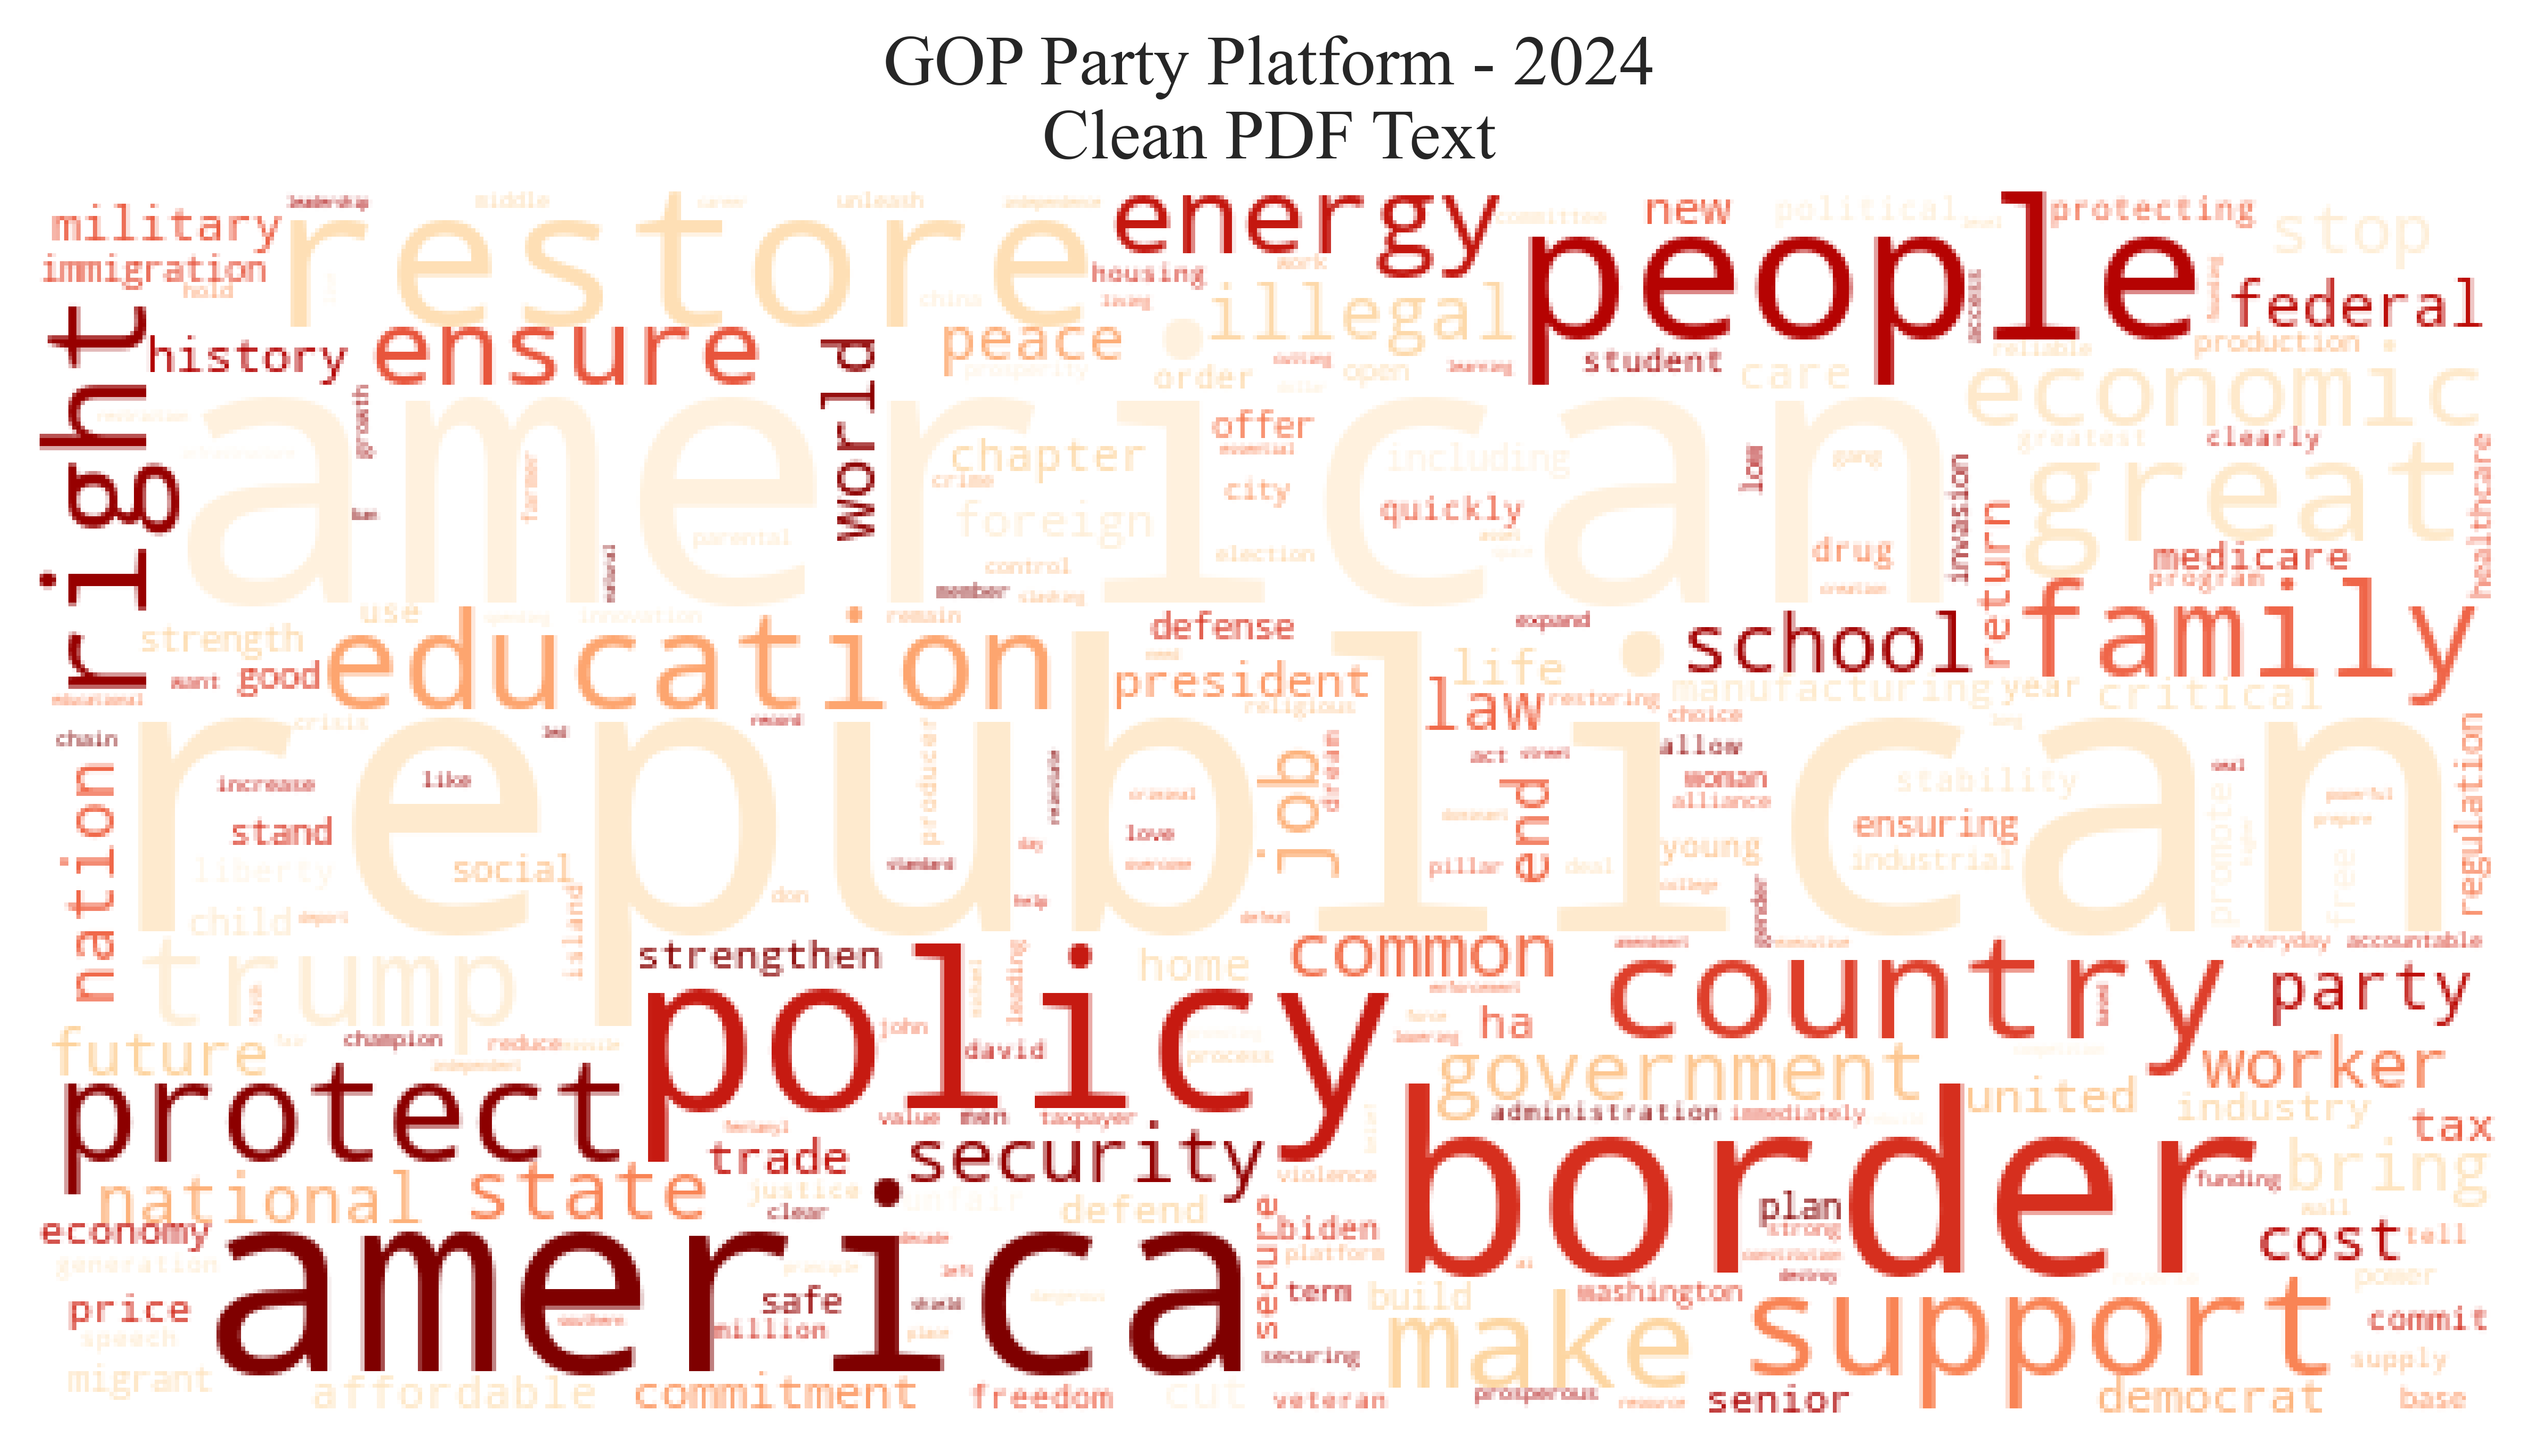

In [316]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='OrRd',max_words=250)
wc.generate_from_frequencies(freq)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("GOP Party Platform - 2024\nClean PDF Text")
plt.savefig("GOP Party Platform - Clean Text",dpi=1000);

In [76]:
democrat_platform_clean = platform_vec_lemmed[platform_vec_lemmed['Party'] == 'Democrat']

In [77]:
freq = democrat_platform_clean.transpose().to_dict()

In [80]:
freq = freq[1]
del freq['Party']

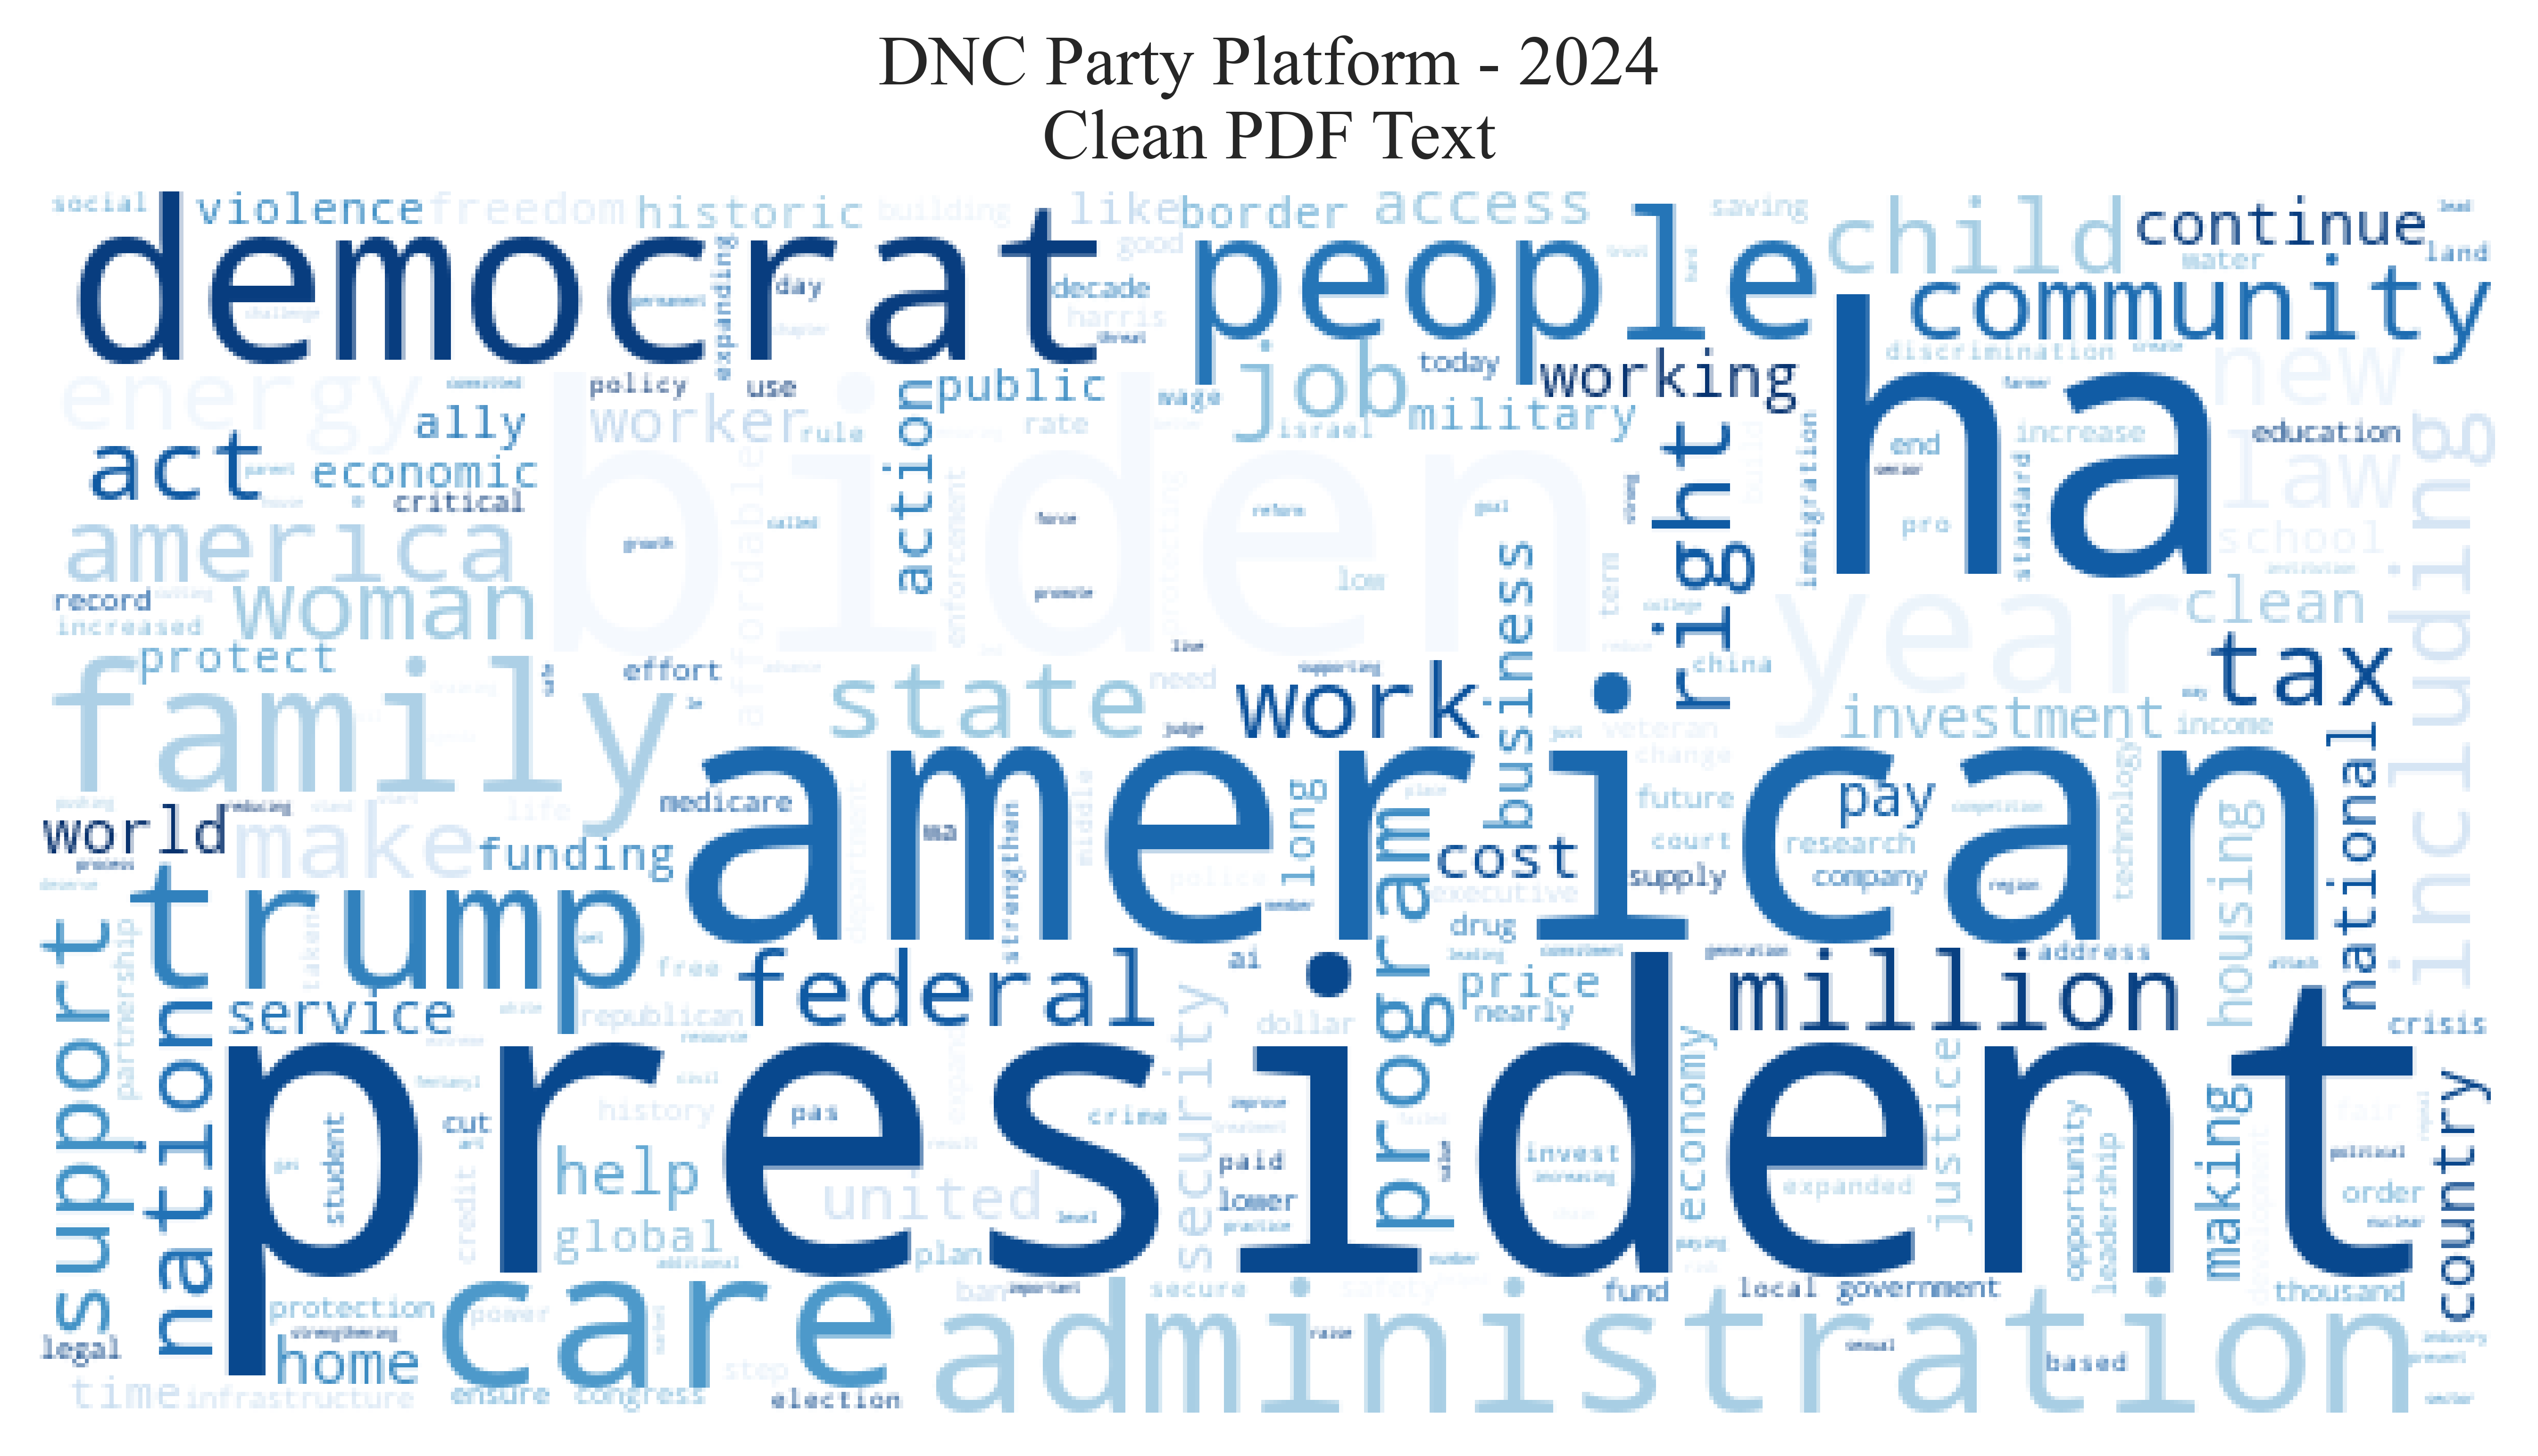

In [87]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1.2)

wc = WordCloud(width=600,height=300, background_color='white',colormap='Blues',max_words=250)
wc.generate_from_frequencies(freq)

## Plotting the cloud

plt.figure(figsize=(9,6),dpi=750)
plt.imshow(wc)
plt.axis('off')
plt.title("DNC Party Platform - 2024\nClean PDF Text")
plt.savefig("DNC Party Platform - Clean Text",dpi=1000);